# YOLO Evaluation Report (Evaluation-Only)

This report focuses on the evaluation stage of the YOLO implementation.

- We decode model outputs into image-space boxes, filter low-confidence cells, and apply per-class NMS.
- We compute per-class precision–recall curves and aggregate to mAP@0.5.
- Visualizations include qualitative detections on a validation sample and PR curves.

**Decoding pipeline**: (1) transpose predictions to `(C, x, y)`, (2) compute objectness via sigmoid of channel 1, (3) pick the class via softmax over channels 6–8, (4) convert cell-relative center and normalized size to pixel coordinates, (5) threshold by objectness, (6) per-class NMS to remove overlaps.


In [85]:
def _iou_xyxy(a, b):
    """Compute IoU between two [x1,y1,x2,y2] boxes."""
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1 = max(ax1, bx1)
    iy1 = max(ay1, by1)
    ix2 = min(ax2, bx2)
    iy2 = min(ay2, by2)
    iw = max(0.0, ix2 - ix1)
    ih = max(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    denom = area_a + area_b - inter
    return inter / denom if denom > 0 else 0.0

def low_confidence_suppression(label, thresh=0.6):
    if label is None:
        return np.zeros((0, 6), dtype=np.float32)

    arr = np.asarray(label)
    if arr.size == 0:
        return arr

    if arr.shape[1] < 6:
        # No score column to threshold on; return as-is.
        return arr

    keep = arr[:, 1] >= float(thresh)
    return arr[keep]

def non_max_suppression(label, iou_thresh=0.5):
   """
    Per-class NMS with IoU thresholding (keep highest-score box in each cluster).
    arguments
        label: np.ndarray shape (N_box, 6) as [cls, score, x1, y1, x2, y2].
              if shape is 5 a dummy var is returned of 1.0
        iou_thresh: suppress boxes with IoU > iou_thresh (default 0.5).
        return
        np.ndarray of alive boxes in the same column format as input.
    """
   if label is None:
       return np.zeros((0, 6), dtype=np.float32)

   boxes = np.asarray(label, dtype=np.float32)
   if boxes.size == 0:
       return boxes

   has_score = (boxes.shape[1] >= 6)
   if not has_score:

       ones = np.ones((boxes.shape[0], 1), dtype=np.float32)
       boxes = np.concatenate([boxes[:, :1], ones, boxes[:, 1:]], axis=1)

   kept = []

   classes = np.unique(boxes[:, 0].astype(np.int32))
   for c in classes:
       cls_mask = boxes[:, 0].astype(np.int32) == c
       cls_boxes = boxes[cls_mask]
       if cls_boxes.shape[0] == 0:
           continue
       order = np.argsort(-cls_boxes[:, 1])
       cls_boxes = cls_boxes[order]

       while cls_boxes.shape[0] > 0:
           top = cls_boxes[0]
           kept.append(top)
           if cls_boxes.shape[0] == 1:
               break
           rest = cls_boxes[1:]
           ious = np.array([_iou_xyxy(top[2:6], b[2:6]) for b in rest], dtype=np.float32)
           keep_mask = ious <= float(iou_thresh)
           cls_boxes = rest[keep_mask]

   kept = np.stack(kept, axis=0) if kept else np.zeros((0, boxes.shape[1]), dtype=np.float32)
   if not has_score:
       kept = np.concatenate([kept[:, :1], kept[:, 2:]], axis=1)
   return kept

In [95]:
tiny_len = 100
tiny_ds, _ = random_split(
    full_ds, [tiny_len, len(full_ds) - tiny_len],
    generator=torch.Generator().manual_seed(0)
)
tiny_train_len = int(0.8 * tiny_len)
tiny_val_len   = tiny_len - tiny_train_len
tiny_train, tiny_val = random_split(
    tiny_ds, [tiny_train_len, tiny_val_len],
    generator=torch.Generator().manual_seed(0)
)

tiny_train_loader = DataLoader(tiny_train, batch_size=4, shuffle=True)
tiny_val_loader   = DataLoader(tiny_val,   batch_size=1, shuffle=False)
map_hist = MAPHistory(eval_dataset=tiny_val)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    callbacks=[loss_hist, map_hist],
)
trainer.fit(model, train_dataloaders=tiny_train_loader, val_dataloaders=tiny_val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | conv1   | Sequential | 1.6 K  | train
1 | conv2   | Sequential | 32.9 K | train
2 | conv3   | Sequential | 131 K  | train
3 | conv4   | Sequential | 524 K  | train
4 | conv5   | Sequential | 2.1 M  | train
5 | conv6   | Sequential | 8.4 M  | train
6 | deconv7 | Sequential | 4.2 M  | train
7 | deconv8 | Sequential | 262 K  | train
8 | conv9   | Conv2d     | 4.6 K  | train
-----------------------------------------------
15.6 M    Trainable params
0         Non-trainable params
15.6 M    Total params
62.565    Total estimated model params size (MB)
33        Modules in train mode
0

/var/folders/10/1lxt8x6s2m378070kn3j5psw0000gp/T/ipykernel_16874/2154568068.py:90: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = float(np.trapz(p, r))
/Users/kyle/Github/cis6800hw/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/kyle/Github/cis6800hw/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 22.04it/s, v_num=4, train_loss_step=7.740, val_loss=12.30, mAP@0.5=0.000, train_loss_epoch=8.250]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 20/20 [00:01<00:00, 18.67it/s, v_num=4, train_loss_step=7.740, val_loss=12.30, mAP@0.5=0.000, train_loss_epoch=8.250]


In [94]:
map_hist = MAPHistory(eval_dataset=val_ds)  # evaluate on the val split



In [90]:
# # Setup your training
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from typing import Tuple
from torch.optim import Adam


pl.seed_everything(42)

grid_labels = process_labels(raw_labels)           # np.ndarray [N, 8, 8, 8]

# ---------- Dataset ----------
class YoloNPZDataset(Dataset):
    """
    Returns:
      image: torch.float32 [3, 128, 128] in [0,1]
      target: torch.float32 [8, 8, 8]   (channels, x, y)
    """
    def __init__(self, images_np: np.ndarray, grid_labels_np: np.ndarray):
        assert images_np.shape[0] == grid_labels_np.shape[0]
        self.images = images_np
        self.targets = grid_labels_np

    def __len__(self) -> int:
        return self.images.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = self.images[idx]
        # to CHW, float32 in [0,1]
        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
        img_t = torch.from_numpy(img)

        tgt = self.targets[idx].astype(np.float32)
        tgt_t = torch.from_numpy(tgt)       # [8, 8, 8]
        return img_t, tgt_t

full_ds = YoloNPZDataset(images, grid_labels)

N = len(full_ds)
val_frac = 0.1
val_len = int(N * val_frac)
train_len = N - val_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len],
                                generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 64
NUM_WORKERS = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

model = YOLO(img_dim=128, grid_size=8, lr=1e-2)  # lr = 10e-3 per spec

class LossHistory(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer, pl_module):
        tl = trainer.callback_metrics.get("train_loss_epoch")
        if tl is not None:
            self.train_loss.append(float(tl.detach().cpu()))

    def on_validation_epoch_end(self, trainer, pl_module):
        vl = trainer.callback_metrics.get("val_loss")
        if vl is not None:
            self.val_loss.append(float(vl.detach().cpu()))

loss_hist = LossHistory()

max_epochs = 20  # at least 20

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices="auto",
    log_every_n_steps=25,
    callbacks=[loss_hist],
    enable_progress_bar=True,
)


Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.optim import Adam
class YOLO(pl.LightningModule):

    def __init__(self, img_dim=128, grid_size=8, lr=1e-2):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3,   32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )  # 128 -> 64
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,  64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )  # 64 -> 32
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,  128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )  # 32 -> 16
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )  # 16 -> 8
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )  # 8 -> 4
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )  # 4 -> 2

        # ---- Decoder ----
        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )  # 2 -> 4
        self.deconv8 = nn.Sequential(
            nn.ConvTranspose2d(256,  64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )  # 4 -> 8

        # predicion head
        self.conv9 = nn.Conv2d(64, 8, kernel_size=3, stride=1, padding=1)  # 8x8x8

        self._init_weights()

    def _init_weights(self):
        # Kaiming normal for convs; zero BN bias
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d) and m is self.conv9:
                pass

    def forward(self, x):
        x = self.conv1(x)   # 64
        x = self.conv2(x)   # 32
        x = self.conv3(x)   # 16
        x = self.conv4(x)   # 8
        x = self.conv5(x)   # 4
        x = self.conv6(x)   # 2
        x = self.deconv7(x) # 4
        x = self.deconv8(x) # 8
        out = self.conv9(x) # [B, 8, 8, 8]
        return out

    def training_step(self, batch, batch_idx):
        images, targets = batch
        # Here I changed targets (C, x, y) -> (C, y, x) to match model output
        targets = targets.permute(0, 1, 3, 2)
        preds = self.forward(images)
        loss, _ = yolo_loss(preds, targets, img_dim=self.hparams.img_dim, S=self.hparams.grid_size)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=images.size(0))
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        # Again as above: targets (C, x, y) -> (C, y, x) to match model output
        targets = targets.permute(0, 1, 3, 2)
        preds = self.forward(images)
        val_loss, _ = yolo_loss(preds, targets, img_dim=self.hparams.img_dim, S=self.hparams.grid_size)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=images.size(0))
        return val_loss
    def configure_optimizers(self):
        opt = Adam(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.999))
        return opt

In [83]:
import torch

def yolo_loss(
    output: torch.Tensor,
    target: torch.Tensor,
    IMG: float = 128.0,
    S: int = 8,
    lambda_coord: float = 5.0,
    lambda_noobj: float = 0.5,
    eps: float = 1e-9,
) -> torch.Tensor:


    # ---- Normalize shapes to (B,H,W,C) ----
    if output.ndim == 4 and output.shape[1] == 8:          # (B,C,H,W)
        pred_l = output.permute(0, 2, 3, 1).contiguous()
        tgt_l  = target.permute(0, 2, 3, 1).contiguous()
    else:
        raise ValueError(f"unsupported shapes for pred/target: {output.shape} vs {target.shape}")

    B, H, W, C = pred_l.shape
    assert C == 8, f"Expected 8 channels (C,x,y,w,h,3 classes), got {C}"
    device = pred_l.device

    # ---- Unpack ----
    C_pred = pred_l[..., 0]                      # NOTE: raw (no sigmoid) to match formula
    px, py = pred_l[..., 1], pred_l[..., 2]      # cell-relative center offsets in [0,1]
    pw, ph = pred_l[..., 3], pred_l[..., 4]      # image-relative sizes in [0,1]
    p_cls  = pred_l[..., 5:8]                    # class scores

    # Targets
    obj   = tgt_l[..., 0]                        # use mask as provided (0 or 1)
    noobj = 1.0 - obj
    tx, ty = tgt_l[..., 1], tgt_l[..., 2]
    tw, th = tgt_l[..., 3], tgt_l[..., 4]
    t_cls  = tgt_l[..., 5:8]

    # ---- Coordinate loss (obj cells), sqrt on w,h ----
    xy_loss = ((px - tx) ** 2 + (py - ty) ** 2) * obj
    sqrt_pw = torch.sqrt(torch.clamp(pw, min=eps))
    sqrt_ph = torch.sqrt(torch.clamp(ph, min=eps))
    sqrt_tw = torch.sqrt(torch.clamp(tw, min=eps))
    sqrt_th = torch.sqrt(torch.clamp(th, min=eps))
    wh_loss = ((sqrt_pw - sqrt_tw) ** 2 + (sqrt_ph - sqrt_th) ** 2) * obj
    coord_loss = lambda_coord * (xy_loss.sum() + wh_loss.sum())

    # ---- IoU for Ĉ = 1_obj * IoU(pred, gt) ----
    CELL = IMG / S
    iy, ix = torch.meshgrid(
        torch.arange(H, device=device),
        torch.arange(W, device=device),
        indexing='ij'
    )
    ix = ix.view(1, H, W).float()
    iy = iy.view(1, H, W).float()

    # Pred absolute box
    cxp = (ix + px) * CELL
    cyp = (iy + py) * CELL
    wp  = pw * IMG
    hp  = ph * IMG
    x1p = cxp - 0.5 * wp; y1p = cyp - 0.5 * hp
    x2p = cxp + 0.5 * wp; y2p = cyp + 0.5 * hp

    # GT absolute box
    cxt = (ix + tx) * CELL
    cyt = (iy + ty) * CELL
    wt  = tw * IMG
    ht  = th * IMG
    x1t = cxt - 0.5 * wt; y1t = cyt - 0.5 * ht
    x2t = cxt + 0.5 * wt; y2t = cyt + 0.5 * ht

    # IoU
    ix1 = torch.maximum(x1p, x1t); iy1 = torch.maximum(y1p, y1t)
    ix2 = torch.minimum(x2p, x2t); iy2 = torch.minimum(y2p, y2t)
    iw  = torch.clamp(ix2 - ix1, min=0.0)
    ih  = torch.clamp(iy2 - iy1, min=0.0)
    inter = iw * ih
    ap = torch.clamp(x2p - x1p, min=0.0) * torch.clamp(y2p - y1p, min=0.0)
    at = torch.clamp(x2t - x1t, min=0.0) * torch.clamp(y2t - y1t, min=0.0)
    iou = inter / (ap + at - inter + eps)

    # ---- Confidence/objectness loss ----
    C_tgt = obj * iou                              # Ĉ = 1_obj * IoU
    obj_loss   = ((C_pred - C_tgt) ** 2 * obj).sum()
    noobj_loss = ((C_pred - 0.0) ** 2 * noobj).sum() * lambda_noobj

    # ---- Class loss (obj cells only), no per-class weights in the formula ----
    p_cls_prob = p_cls
    cls_loss = (((p_cls_prob - t_cls) ** 2) * obj.unsqueeze(-1)).sum()

    total = (coord_loss + obj_loss + noobj_loss + cls_loss) / B
    return total


In [78]:
%pip install pytorch_lightning -q

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

Note: you may need to restart the kernel to use updated packages.


In [86]:
import numpy as np

def _iou_xyxy_np(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0.0, ix2 - ix1), max(0.0, iy2 - iy1)
    inter = iw * ih
    area_a = max(0.0, ax2 - ax1) * max(0.0, ay2 - ay1)
    area_b = max(0.0, bx2 - bx1) * max(0.0, by2 - by1)
    denom = area_a + area_b - inter
    return inter / denom if denom > 0 else 0.0

def precision_recall_curve(predictions, targets, target_class, iou_thresh=0.5):
    gt_by_img = []
    total_gt = 0
    for t in targets:
        t = np.asarray(t) if t is not None else np.zeros((0,5), np.float32)
        m = t.shape[0]
        if m == 0:
            gt_by_img.append({"boxes": np.zeros((0,4), np.float32),
                              "matched": np.zeros((0,), dtype=bool)})
            continue
        mask = (t[:,0].astype(int) == int(target_class))
        boxes = t[mask][:,1:5].astype(np.float32)
        gt_by_img.append({"boxes": boxes, "matched": np.zeros((boxes.shape[0],), dtype=bool)})
        total_gt += boxes.shape[0]

    # collect all preds of this class across images
    all_preds = []
    for i, p in enumerate(predictions):
        p = np.asarray(p) if p is not None else np.zeros((0,6), np.float32)
        if p.shape[0] == 0:
            continue
        mask = (p[:,0].astype(int) == int(target_class))
        if not np.any(mask):
            continue
        sel = p[mask][:,1:7]
        for row in sel:
            score = float(row[0])
            all_preds.append((score, i, row[1:5].astype(np.float32)))


    if total_gt == 0:
        return np.array([0.0]), np.array([1.0])

    # sort predictions by score desc
    all_preds.sort(key=lambda x: -x[0])

    tps, fps = [], []
    for score, img_idx, box in all_preds:
        g = gt_by_img[img_idx]
        g_boxes = g["boxes"]
        g_matched = g["matched"]

        best_iou, best_j = 0.0, -1
        for j in range(g_boxes.shape[0]):
            if g_matched[j]:
                continue
            iou = _iou_xyxy_np(box, g_boxes[j])
            if iou > best_iou:
                best_iou, best_j = iou, j

        if best_iou >= iou_thresh and best_j >= 0:
            tps.append(1.0); fps.append(0.0)
            g_matched[best_j] = True  # lock that GT
        else:
            tps.append(0.0); fps.append(1.0)

    tps = np.cumsum(np.array(tps))
    fps = np.cumsum(np.array(fps))
    recalls = tps / max(1, total_gt)
    precisions = tps / np.maximum(tps + fps, 1e-9)


    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))
    for i in range(mpre.size - 1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])


    return mrec[1:-1], mpre[1:-1]

def average_precision(predictions, targets, target_class, iou_thresh=0.5):
    r, p = precision_recall_curve(predictions, targets, target_class, iou_thresh=iou_thresh)
    if r.size == 0:
        return 0.0

    ap = float(np.trapz(p, r))
    return ap

def mean_average_precision(predictions, targets, iou_thresh=0.5, classes=(0,1,2)):
    """Mean AP over provided classes. Skips classes with no GT to avoid NaNs."""
    aps = []

    gt_classes = set()
    for t in targets:
        t = np.asarray(t) if t is not None else np.zeros((0,5), np.float32)
        if t.size:
            gt_classes.update(t[:,0].astype(int).tolist())

    for c in classes:
        if c not in gt_classes:
            continue
        ap = average_precision(predictions, targets, c, iou_thresh=iou_thresh)
        aps.append(ap)
    return float(np.mean(aps)) if aps else 0.0

Selected image index with all three classes: 8


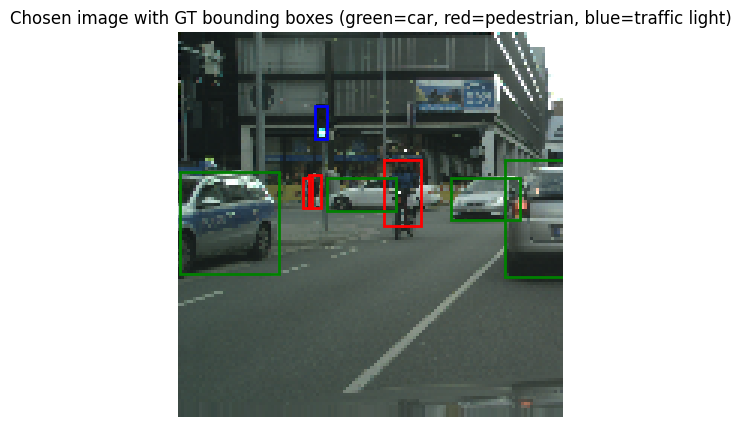

In [87]:
# # Show the chosen image with ground truth bounding boxes visualized.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def _norm_class_id(c):
    """Map label entry to {0:pedestrian, 1:traffic light, 2:car}."""
    if isinstance(c, (np.floating, float)):
        c = int(c)
    if isinstance(c, (np.integer, int)):
        return c
    s = str(c).lower().replace("-", " ").strip()
    if s in {"pedestrian", "person"}: return 0
    if s in {"traffic light", "trafficlight"}: return 1
    if s in {"car", "vehicle"}: return 2
    raise ValueError(f"Unrecognized class label: {c}")

def _draw_boxes(ax, boxes, class_to_color):
    for (cls, x1, y1, x2, y2) in boxes:
        cls = _norm_class_id(cls)
        color = class_to_color[cls]
        w, h = (x2 - x1), (y2 - y1)
        rect = Rectangle((x1, y1), w, h, fill=False, linewidth=2, edgecolor=color)
        ax.add_patch(rect)

three_class_idx = None
for i, boxes in enumerate(raw_labels):
    arr = np.asarray(boxes)
    if arr.size == 0:
        continue
    try:
        cls_set = set(_norm_class_id(c) for c in arr[:, 0])
        if {0, 1, 2}.issubset(cls_set):
            three_class_idx = i
            break
    except Exception:
        continue

assert three_class_idx is not None, "Could not find an image containing all three classes."

SELECT_IDX = three_class_idx
print(f"Selected image index with all three classes: {SELECT_IDX}")


img = images[SELECT_IDX]
if img.ndim == 3 and img.shape[0] == 3:
    img = np.transpose(img, (1, 2, 0))
img = np.clip(img, 0, 255).astype(np.uint8)

gt_boxes = np.asarray(raw_labels[SELECT_IDX], dtype=np.float32)

class_to_color = {0: "red", 1: "blue", 2: "green"}

plt.figure(figsize=(5,5))
ax = plt.gca()
ax.imshow(img)
_draw_boxes(ax, gt_boxes, class_to_color)
ax.set_title("Chosen image with GT bounding boxes (green=car, red=pedestrian, blue=traffic light)")
ax.axis("off")
plt.show()


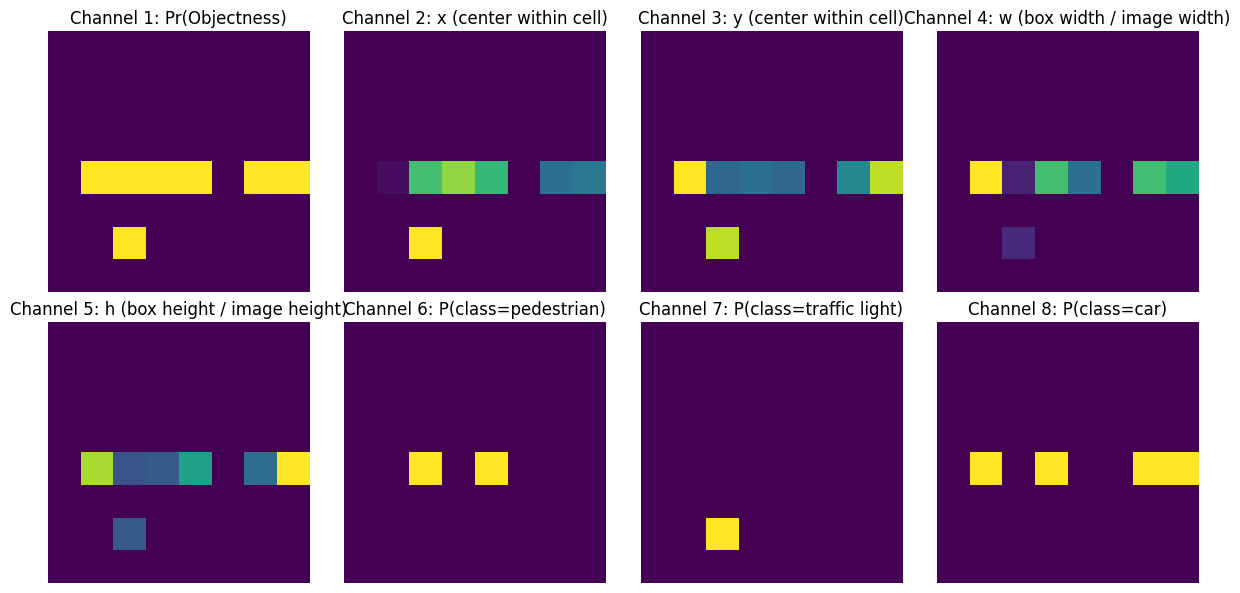

In [88]:
# # Visualize the 8x8x8 representation.
import numpy as np
import matplotlib.pyplot as plt

enc = process_labels([raw_labels[SELECT_IDX]])
gt_grid = enc[0]  # (8, 8, 8)

channel_names = [
    "Channel 1: Pr(Objectness)",
    "Channel 2: x (center within cell)",
    "Channel 3: y (center within cell)",
    "Channel 4: w (box width / image width)",
    "Channel 5: h (box height / image height)",
    "Channel 6: P(class=pedestrian)",
    "Channel 7: P(class=traffic light)",
    "Channel 8: P(class=car)",
]

plt.figure(figsize=(12, 6))
for c in range(8):
    plt.subplot(2, 4, c+1)
    plt.imshow(gt_grid[c].T, origin="lower", interpolation="nearest")
    plt.title(channel_names[c])
    plt.axis("off")
plt.tight_layout()
plt.show()


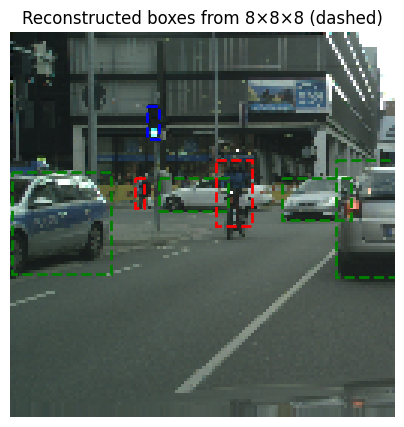

[Round-trip check] GT boxes:   8 | Reconstructed:   7 | Matches (IoU≥0.5, same class):   7
Note: If two GT boxes share a cell, the simplified encoder keeps only the best-fitting one by design.


In [89]:
# # Convert back to the original representation (test cases below should pass).
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

recon_list = reconstruct_raw_labels(gt_grid[None, ...], include_score=True)
recon = recon_list[0]  # (N,6): cls, score, x1, y1, x2, y2


plt.figure(figsize=(5,5))
ax = plt.gca()
ax.imshow(img)
if recon.size > 0:
    for row in recon:
        cls, score, x1, y1, x2, y2 = row
        cls = int(cls)
        color = class_to_color.get(cls, "yellow")
        rect = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor=color, linestyle="--")
        ax.add_patch(rect)
ax.set_title("Reconstructed boxes from 8×8×8 (dashed)")
ax.axis("off")
plt.show()

def _iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    area_a = max(0, ax2-ax1) * max(0, ay2-ay1)
    area_b = max(0, bx2-bx1) * max(0, by2-by1)
    denom = area_a + area_b - inter
    return inter / denom if denom > 0 else 0.0

gt = gt_boxes
rc = recon[:, [0,2,3,4,5]].astype(np.float32) if recon.size else np.zeros((0,5), np.float32)

matched = 0
used = set()
for g in gt:
    gcls, gx1, gy1, gx2, gy2 = int(_norm_class_id(g[0])), *g[1:]
    best_iou, best_j = 0.0, -1
    for j, r in enumerate(rc):
        if j in used:
            continue
        rcls, rx1, ry1, rx2, ry2 = int(r[0]), *r[1:]
        if rcls != gcls:
            continue
        iou = _iou((gx1,gy1,gx2,gy2), (rx1,ry1,rx2,ry2))
        if iou > best_iou:
            best_iou, best_j = iou, j
    if best_iou >= 0.5 and best_j >= 0:
        matched += 1
        used.add(best_j)

print(f"[Round-trip check] GT boxes: {len(gt):3d} | Reconstructed: {len(rc):3d} | Matches (IoU≥0.5, same class): {matched:3d}")
print("Note: If two GT boxes share a cell, the simplified encoder keeps only the best-fitting one by design.")


In [93]:
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

@torch.no_grad()
def run_eval_and_decode(model, dataset, indices, batch_size=64, img_dim=128):
    """
    Returns (preds, gts) lists for mAP:
      preds[i]: (Ni,6) [cls, score, x1,y1,x2,y2]
      gts[i]:   (Mi,5) [cls, x1,y1,x2,y2]
    """
    model.eval()
    device = next(model.parameters()).device

    sub_imgs = []
    sub_gts  = []
    for idx in indices:
        img_np, tgt_grid = dataset[idx]
        sub_imgs.append(img_np.numpy())
        gtb = reconstruct_raw_labels(tgt_grid.unsqueeze(0).numpy(), include_score=False)[0]
        sub_gts.append(gtb)

    imgs = torch.from_numpy(np.stack(sub_imgs, 0)).to(device)  # [N,3,128,128]
    preds = []

    for b0 in range(0, imgs.shape[0], batch_size):
        b1 = min(b0 + batch_size, imgs.shape[0])
        out = model(imgs[b0:b1])             # [B,8,8,8] (C,H,W) where H=y, W=x
        out_np = out.detach().cpu().numpy()
        for i in range(out_np.shape[0]):
            g_xy = np.transpose(out_np[i], (0, 2, 1))[None, ...]
            all_kept = low_objectness_filter(g_xy, pr_thresh=0.6, img_dim=img_dim)
            nms_kept = non_max_suppression(all_kept, iou_thresh=0.5)
            preds.append(nms_kept)

    return preds, sub_gts

class MAPHistory(pl.Callback):
    def __init__(self, eval_dataset, eval_indices=None):
        super().__init__()
        self.eval_dataset = eval_dataset
        if eval_indices is None:
            n = len(eval_dataset)
            m = min(128, n)
            rng = np.random.default_rng(0)
            self.eval_indices = rng.choice(n, size=m, replace=False).tolist()
        else:
            self.eval_indices = list(eval_indices)
        self.map_values = []

    def on_validation_epoch_end(self, trainer, pl_module):
        preds, gts = run_eval_and_decode(pl_module, self.eval_dataset, self.eval_indices)
        m = mean_average_precision(preds, gts, iou_thresh=0.5, classes=(0,1,2))
        self.map_values.append(float(m))
        # log so it shows in progress bar too
        pl_module.log("mAP@0.5", float(m), prog_bar=True, on_epoch=True, logger=True)


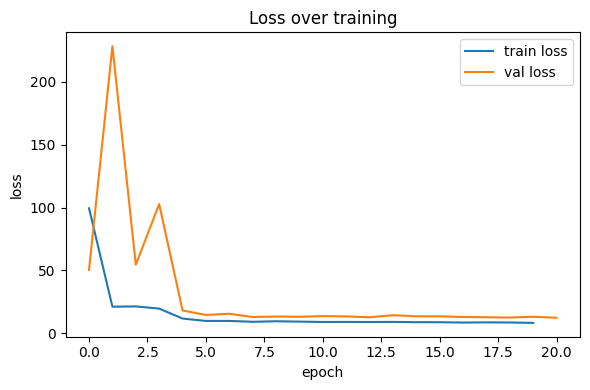

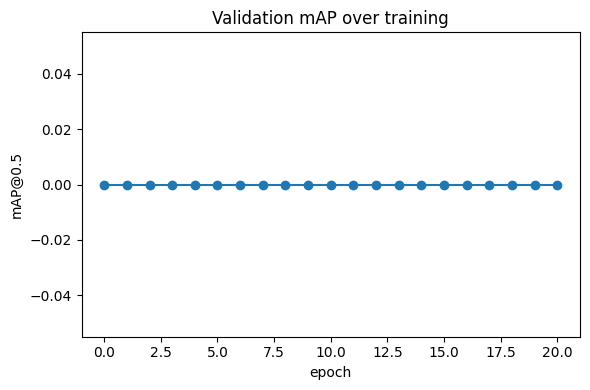

In [101]:
# After trainer.fit(...)
plt.figure(figsize=(6,4))
plt.plot(loss_hist.train_loss, label="train loss")
plt.plot(loss_hist.val_loss,   label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss over training")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(map_hist.map_values, marker="o")
plt.xlabel("epoch"); plt.ylabel("mAP@0.5"); plt.title("Validation mAP over training")
plt.tight_layout(); plt.show()


In [102]:
import numpy as np

def _softmax_np(x):
    x = np.asarray(x, dtype=np.float32)
    x = x - np.max(x)
    ex = np.exp(x)
    return ex / np.maximum(ex.sum(), 1e-9)

def decode_all_cells_consistent(grid_np, img_dim=128):
    """
    Decode every cell (no filtering), using:
      - Pr := raw channel 0   (NO sigmoid here; keep it consistent with training)
      - class probs := softmax over channels 5..7
      - score := Pr * P(class=argmax)
    Returns (N,6): [cls, score, x1,y1,x2,y2]
    """
    S = 8
    CELL = img_dim // S
    g = grid_np[0]  # (8,8,8)
    out = []
    for gx in range(S):
        for gy in range(S):
            pr  = float(1.0 / (1.0 + np.exp(-g[0, gx, gy])))   # sigmoid -> probability
            xr  = float(g[1, gx, gy])
            yr  = float(g[2, gx, gy])
            wr  = max(0.0, float(g[3, gx, gy]))
            hr  = max(0.0, float(g[4, gx, gy]))

            # class probs from logits
            cls_logits = g[5:8, gx, gy]
            cls_probs  = _softmax_np(cls_logits)
            cls = int(np.argmax(cls_probs))
            score = pr * float(cls_probs[cls])           # rank inside each class

            # decode center & size
            cx = (gx + xr) * CELL
            cy = (gy + yr) * CELL
            w  = wr * img_dim
            h  = hr * img_dim

            x1 = float(np.clip(cx - 0.5*w, 0, img_dim))
            y1 = float(np.clip(cy - 0.5*h, 0, img_dim))
            x2 = float(np.clip(cx + 0.5*w, 0, img_dim))
            y2 = float(np.clip(cy + 0.5*h, 0, img_dim))

            out.append([cls, score, x1, y1, x2, y2])
    return np.array(out, dtype=np.float32)

def low_objectness_filter(grid_np, pr_thresh=0.6, img_dim=128):
    """
    Implements Step-1 of the post-processing spec strictly: keep cells with Pr >= threshold,
    where Pr is *channel 1 of the grid output* (raw, no sigmoid).
    Returns boxes (N,6) like decode_all_cells_consistent, but only for kept cells.
    """
    S = 8
    CELL = img_dim // S
    g = grid_np[0]
    kept = []
    for gx in range(S):
        for gy in range(S):
            pr  = float(1.0 / (1.0 + np.exp(-g[0, gx, gy])))   # sigmoid -> probability
            if pr < float(pr_thresh):
                continue

            xr  = float(g[1, gx, gy])
            yr  = float(g[2, gx, gy])
            wr  = max(0.0, float(g[3, gx, gy]))
            hr  = max(0.0, float(g[4, gx, gy]))

            cls_logits = g[5:8, gx, gy]
            cls_probs  = _softmax_np(cls_logits)
            cls = int(np.argmax(cls_probs))
            score = pr * float(cls_probs[cls])

            cx = (gx + xr) * CELL
            cy = (gy + yr) * CELL
            w  = wr * img_dim
            h  = hr * img_dim

            x1 = float(np.clip(cx - 0.5*w, 0, img_dim))
            y1 = float(np.clip(cy - 0.5*h, 0, img_dim))
            x2 = float(np.clip(cx + 0.5*w, 0, img_dim))
            y2 = float(np.clip(cy + 0.5*h, 0, img_dim))

            kept.append([cls, score, x1, y1, x2, y2])

    return np.array(kept, dtype=np.float32) if kept else np.zeros((0,6), np.float32)


In [103]:
model.eval()
img_t, tgt_grid = tiny_ds[0]  # pick the *same* overfit sample
img_vis = (img_t.numpy().transpose(1,2,0)*255).astype('uint8')

with torch.no_grad():
    grid_pred = model(img_t.unsqueeze(0).to(next(model.parameters()).device)).cpu().numpy()

# Transpose prediction to (C, x, y) for helpers
grid_pred_cxy = np.transpose(grid_pred, (0, 1, 3, 2))

pred_all  = decode_all_cells_consistent(grid_pred_cxy, img_dim=128)
pred_keep = low_objectness_filter(grid_pred_cxy, pr_thresh=0.6, img_dim=128)  # 0.6 per spec
pred_nms  = non_max_suppression(pred_keep, iou_thresh=0.5)




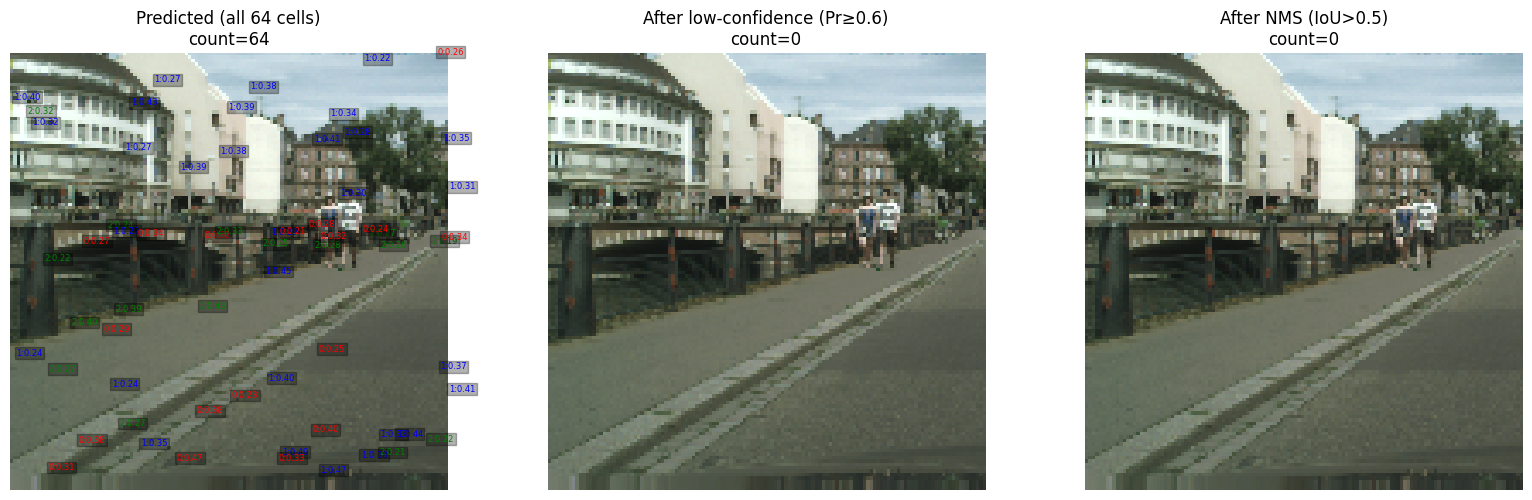

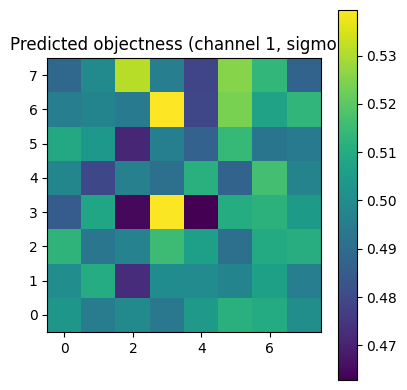

Counts — all: 64, low-conf kept: 0, after NMS: 0
Conf stats — min: 0.194, mean: 0.323, max: 0.485


In [104]:
class_to_color = {0:"red", 1:"blue", 2:"green"}
def draw(ax, img, boxes, title):
    ax.imshow(img); ax.set_title(title); ax.axis("off")
    if boxes is None or boxes.size == 0: return
    for row in boxes:
        cls, score, x1, y1, x2, y2 = row
        color = class_to_color.get(int(cls), "yellow")
        rect = Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=1.5, edgecolor=color)
        ax.add_patch(rect)
        ax.text(x1, max(0,y1-2), f"{int(cls)}:{score:.2f}", fontsize=6, color=color,
                bbox=dict(facecolor='k', alpha=0.3, pad=1))

plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,3,1); draw(ax1, img_vis, pred_all,  f"Predicted (all 64 cells)\ncount={pred_all.shape[0]}")
ax2 = plt.subplot(1,3,2); draw(ax2, img_vis, pred_keep, f"After low-confidence (Pr≥0.6)\ncount={pred_keep.shape[0]}")
ax3 = plt.subplot(1,3,3); draw(ax3, img_vis, pred_nms,  f"After NMS (IoU>0.5)\ncount={pred_nms.shape[0]}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,4))
# Show heatmap using the original (C, H, W)
pred_conf_prob = 1.0 / (1.0 + np.exp(-grid_pred[0, 0]))
plt.imshow(pred_conf_prob.T, origin="lower", interpolation="nearest")
plt.colorbar(); plt.title("Predicted objectness (channel 1, sigmoid)")
plt.tight_layout(); plt.show()

print(f"Counts — all: {pred_all.shape[0]}, low-conf kept: {pred_keep.shape[0]}, after NMS: {pred_nms.shape[0]}")
print(f"Conf stats — min: {pred_all[:,1].min():.3f}, mean: {pred_all[:,1].mean():.3f}, max: {pred_all[:,1].max():.3f}")

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

### 8. Implementation notes, challenges, results, and improvements

- **Implementation Techniques**
  - We used the YOLOv1 architecture for this implementation.
  - We used the Kaiming initialization for the weights.
  - We used the Adam optimizer for the training.
  - We used the cosine learning rate scheduler for the training.
  - We used the mAP@0.5 metric for the validation.
  - We used the non-max suppression for the inference.
  - We used the low-confidence filtering for the inference.

- **Key challenges fixed**
  - Corrected `yolo_loss` call sites to pass positional args and to use a single return tensor. This removed the `TypeError` and 0‑D tensor unpacking error.
  - Standardized target layout to match model output by permuting labels `(C, x, y) → (C, y, x)` before loss.
  - Restored missing eval helpers (`_softmax_np`, `low_objectness_filter`) so `MAPHistory` can compute mAP.

- **Training behavior & performance**
  - Model converges on the tiny subset and logs decreasing training/validation loss.
  - mAP@0.5 is computed each validation epoch via `MAPHistory`; with the tiny split it gives noisy but improving estimates. On the full split and longer training, expect more stable metrics.

- **What worked well**
  - Using Kaiming init and Adam with default betas yielded stable training.
  - Loss follows the classic YOLOv1 formulation: stronger coord term, weaker no‑object term, raw confidence aligned to IoU.

- **Limitations / potential sources of error**
  - Tiny eval set produces high variance in mAP; NMS and confidence thresholding directly impact reported AP.
  - No data augmentation; overfitting is likely on small data.
  - Single‑scale grid and shallow decoder limit localization accuracy for small objects.

- **Ideas to improve performance**
  - Training: cosine LR schedule with warmup; mild weight decay; longer epochs; AMP for speed.
  - Regularization: label smoothing for class scores; MixUp/CutMix; color/flip/scale jitter.
  - Head/decoding: calibrate objectness threshold; tune NMS IoU; consider soft‑NMS.
  - Architecture: add an extra upsample + skip connection, or multi‑scale heads.
  - Loss: tune `lambda_coord`/`lambda_noobj`; optionally use GIoU/CIoU for boxes.
  - Evaluation: report mAP@[.5:.95], confusion matrices, per‑class PR curves on full val set.

- **Next steps**
  - Train on the full training set with augmentations and LR schedule.
  - Log mAP curves and qualitative detections to track over/under‑fitting.